# Notebook: 10 Passos para implementar uma Rede Neural Convolucional para classificação de imagens (Biblioteca Keras)

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/drive/1Xk7vSQJBOu2rjXlpQdU-HV5pEVdTm7aG)

## **Programa de Pós-Graduação PPG TIG Saúde**
### Tópicos Avançados em Informática Biomédica
#### *Mestranda: Dieine Bernieri Schiavon (bsandrade11@gmail.com)*

In [1]:
## Carregando as bibliotecas necessárias
# A primeira linha é incluída para gerar os gráficos logo abaixo dos comandos de plot
%matplotlib inline
import pandas as pd             # biblioteca para análise de dados
import matplotlib.pyplot as plt # biblioteca para visualização de informações
import seaborn as sns           # biblioteca para visualização de informações
import numpy as np              # biblioteca para operações com arrays multidimensionais
sns.set()

## Bibliotecas para treinamento/avaliação de modelos
from sklearn.model_selection import RepeatedKFold, StratifiedKFold, train_test_split, cross_validate, cross_val_score, cross_val_predict
from sklearn import metrics

## Bibliotecas para as imagens
import os
import cv2
from PIL import Image
from skimage.transform import resize

# Design dos gráficos
plt.style.use('ggplot')

sns.set()


# Etapas

1. Baixar o dataset
2. Numerar as classes
3. Fazer o train_test_split
4. Transformar (X-train, y_train e X_test e y_test) em array
5. Arquitetura do Modelo e Hiperparâmetros
6. Ativar o otimizador
7. Realizar o "model.fit", ou seja o treinamento do modelo
8. Plotar as curvas de aprendizagem
9. Plotar a matriz de confusão
10. Plotar as predições (outputs) do modelo -> aqui compara o rótulo real com o que foi predito.

# 1) Baixando o Dataset

> Nota: Reduzi a quantidade de imagens do banco de dados original para agilizar o processo de treinamento da rede para a aula. O banco de dados completo e informações sobre o dataset você encontra no link: [Brain Tumor Classification](https://www.kaggle.com/datasets/sartajbhuvaji/brain-tumor-classification-mri)

> Ou nesse [Link](https://github.com/sartajbhuvaji/brain-tumor-classification-dataset) - GitHub do próprio autor.

In [17]:
from tqdm import tqdm #Import para progressbar

datadir = '/content/drive/MyDrive/sartaj_small/Training' # Modificar para o seu diretório no Colab
categories = ['no_tumor', 'meningioma', 'pituitary', 'glioma']
X = []
y = []
image_shape = (128,128,1)

for category in categories:
    path = os.path.join(datadir, category)
    for image in tqdm(os.listdir(path), desc=f'Processing {category}'):
        images = cv2.imread(os.path.join(path, image))
        color = cv2.imread(path, cv2.COLOR_BGR2GRAY)
        images = resize(images, (image_shape), mode = 'constant', preserve_range = True)
        images = np.array(images)
        X.append(images)
        y.append(categories.index(category))

Processing glioma: 100%|██████████| 507/507 [00:26<00:00, 19.39it/s]


In [18]:
# Classes/ Rótulos / Labels
categories

['no_tumor', 'meningioma', 'pituitary', 'glioma']

## 2) Numerar as Classes transformando em one_hot_encoding
```python
- '0' = [1, 0, 0, 0]
- '1' = [0, 1, 0, 0]
- '2' = [0, 0, 1, 0]
- '3' = [0, 0, 0, 1]
```

In [19]:
import numpy as np

# Determina o número total de classes (classes_num)
classes = np.unique(y)
classes_num = len(classes)

# Cria a representação one-hot
one_hot_encoding = np.zeros((len(y), classes_num))
for i, label in enumerate(y):
    one_hot_encoding[i, label] = 1

# Agora, 'one_hot_encoding' conterá os vetores one-hot correspondentes aos rótulos numéricos

# Exemplo de saída:
print(one_hot_encoding)


[[1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 ...
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]]


## Plotar o número de imagens que contém cada pasta(classe)

In [20]:
no_tumor = 0
meningioma = 0
pituitary = 0
glioma = 0

for i in range(len(y)):
    if y[i] == 0:
        no_tumor += 1
    elif y[i] == 1:
        meningioma += 1
    elif y[i] == 2:
        pituitary += 1
    elif y[i] == 3:
        glioma += 1

print("Total Images: ", len(y))
print("Total Images - No Tumor: ", no_tumor)
print("Total Images - Meningioma: ", meningioma)
print("Total Images - Pituitary: ", pituitary)
print("Total Images - Glioma: ", glioma)

Total Images:  1790
Total Images - No Tumor:  466
Total Images - Meningioma:  409
Total Images - Pituitary:  408
Total Images - Glioma:  507


## 3) Realizar a divisão dos dados para treinamento e teste(também podemos chamar de validação)

## 4) Transforma `X_train, y_train e X_test e y_test` em array

In [21]:
from sklearn.model_selection import train_test_split

# Split o dataset em treino e teste
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Transformar em array numpy
X_train = np.array(x_train)
y_train = np.array(y_train)
X_test = np.array(x_test)
y_test = np.array(y_test)

# É sempre bom imprimir suas formas!
print("Number of samples in the training set (x_train):", len(X_train))
print("X_train shape: ", X_train.shape)
print("Number of samples in the testing set (x_test):", len(X_test))
print("X_test shape: ", X_test.shape)

Number of samples in the training set (x_train): 1432
X_train shape:  (1432, 128, 128, 1)
Number of samples in the testing set (x_test): 358
X_test shape:  (358, 128, 128, 1)


## 5) Arquitetura da Rede Neural Convolucional e hiperparâmetros
## 6) Compilar o modelo `model compile`

In [22]:
# Usando as bibliotecas do keras para implementação da rede
import keras
from keras import layers
from keras.models import Sequential
from keras.layers import Conv2D, MaxPool2D, Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Rescaling, GlobalAveragePooling2D
from keras.regularizers import l2

input_shape = (128,128,1)

model = Sequential()
model.add(Rescaling(1./255, input_shape=input_shape))  #Normaliza antes da entrada na rede

model.add(Conv2D(filters=16, kernel_size=5, strides = 2, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.1))

model.add(Conv2D(filters=32, kernel_size=3, strides = 2, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.15))

model.add(Conv2D(filters=64, kernel_size=3, strides = 2, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

#Flatten
model.add(Flatten())

model.add(Dense(32, activation='relu'))
model.add(Dense(32, activation='relu', kernel_regularizer=l2(0.01)))
model.add(Dense(4, activation='softmax'))

#Adam Compiler/ Compilador Adam - learning_rate= 0.001
model.compile(optimizer = 'adam' , loss = "sparse_categorical_crossentropy", metrics = ["accuracy"])
model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 128, 128, 1)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 64, 64, 16)        416       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 32, 32, 16)        0         
 g2D)                                                            
                                                                 
 dropout_3 (Dropout)         (None, 32, 32, 16)        0         
                                                                 
 conv2d_4 (Conv2D)           (None, 16, 16, 32)        4640      
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 8, 8, 32)          0         
 g2D)                                                 

## Para evitar overfitting:

1. **A regularização L2**

A regularização L2 (também conhecida como norma L2 ou regularização de peso L2) é uma técnica comum usada em aprendizado de máquina e redes neurais para evitar o overfitting, melhorar a generalização do modelo e reduzir pesos excessivamente grandes nos neurônios da rede. Funciona da seguinte maneira:

**Adição de Termo de Regularização L2 à Função de Perda:** A regularização L2 envolve a adição de um termo de regularização à função de perda original durante o treinamento. Esse termo é calculado somando o quadrado de todos os pesos da rede neural e multiplicando-o por um hiperparâmetro chamado de "parâmetro de regularização" ou "coeficiente de regularização" (geralmente denotado por λ ou alpha). O objetivo é minimizar esse termo de regularização, juntamente com a função de perda original.

2. **Dropout**

O Dropout é outra técnica de regularização usada em redes neurais para combater o overfitting e melhorar a generalização do modelo. A ideia principal por trás do Dropout é desativar aleatoriamente (ou "abandonar") um subconjunto de neurônios durante o treinamento. Isso impede que a rede neural se torne excessivamente dependente de neurônios específicos e, portanto, torna o modelo mais robusto. Veja como o Dropout funciona:

## 7) Agora vamos treinar o modelo (`model.fit`)

In [23]:
history = model.fit(
    X_train,
    y_train,
    epochs=30,
    batch_size = 32,
    validation_data=(X_test, y_test))

Epoch 1/30
45/45 [==============================] - 3s 16ms/step - loss: 1.6270 - accuracy: 0.3170 - val_loss: 1.5215 - val_accuracy: 0.5112
Epoch 2/30
45/45 [==============================] - 1s 14ms/step - loss: 1.2481 - accuracy: 0.5663 - val_loss: 0.9094 - val_accuracy: 0.6955
Epoch 3/30
45/45 [==============================] - 0s 8ms/step - loss: 0.8090 - accuracy: 0.7444 - val_loss: 0.7583 - val_accuracy: 0.7709
Epoch 4/30
45/45 [==============================] - 0s 7ms/step - loss: 0.6478 - accuracy: 0.7954 - val_loss: 0.6782 - val_accuracy: 0.7430
Epoch 5/30
45/45 [==============================] - 0s 8ms/step - loss: 0.5744 - accuracy: 0.8226 - val_loss: 0.5570 - val_accuracy: 0.8240
Epoch 6/30
45/45 [==============================] - 0s 8ms/step - loss: 0.5022 - accuracy: 0.8401 - val_loss: 0.4995 - val_accuracy: 0.8464
Epoch 7/30
45/45 [==============================] - 0s 8ms/step - loss: 0.4805 - accuracy: 0.8520 - val_loss: 0.4864 - val_accuracy: 0.8436
Epoch 8/30
45/45 [

## 8) Plotando as curvas de treinamento

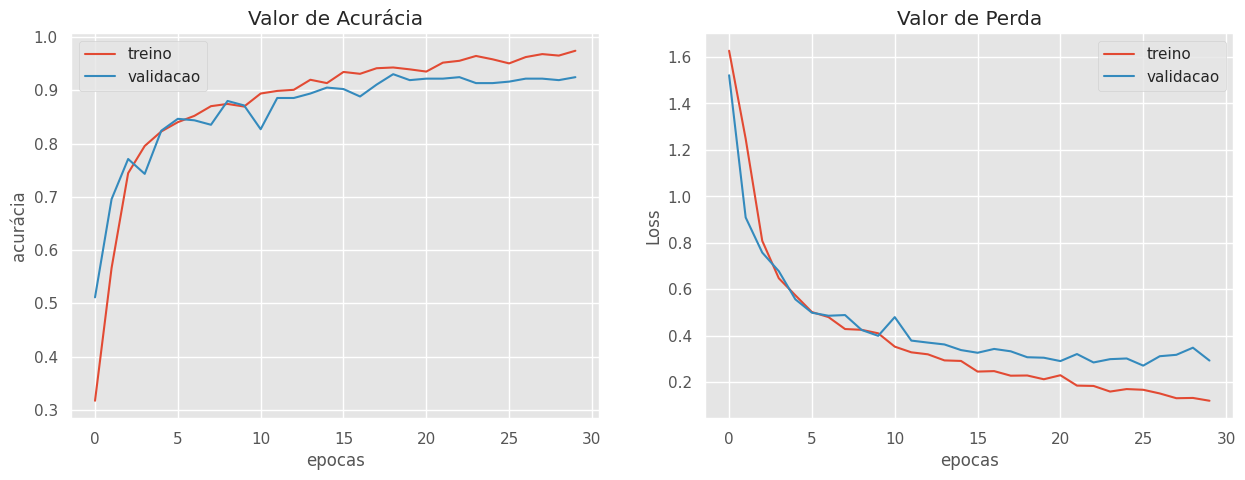

In [24]:
plt.style.use('ggplot')

plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.title('Valor de Acurácia')
plt.plot(history.history["accuracy"], label="treino")
plt.plot(history.history["val_accuracy"], label="validacao")
plt.xlabel("epocas")
plt.ylabel("acurácia")
plt.legend();

plt.subplot(1,2,2)
plt.title('Valor de Perda')
plt.plot(history.history["loss"], label="treino")
plt.plot(history.history["val_loss"], label="validacao")
plt.xlabel("epocas")
plt.ylabel("Loss")

plt.legend();

## Salvando o modelo treinado 🤖

In [25]:
# Salva todo o modelo, incluindo a arquitetura e os pesos:
model.save('/content/drive/MyDrive/ONE_full_model.h5') # Salve no seu diretório, pois nesse formato salva temporariamente na pasta  /content do Colab

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [26]:
# Salva os pesos do modelo em um arquivo
model.save('/content/drive/MyDrive/ONE_weights_model.h5') # Salve no seu diretório, pois nesse formato salva temporariamente na pasta  /content do Colab

## 9) Plotando a Matriz de Confusão Básica e outra mais elaborada

In [27]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# predição
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)

cmat = confusion_matrix(y_test, y_pred)
cmat

12/12 [==============================] - 0s 3ms/step


array([[ 76,  13,   3,   1],
       [  5,  74,   3,   0],
       [  2,   0,  80,   0],
       [  0,   0,   0, 101]])

12/12 [==============================] - 0s 3ms/step


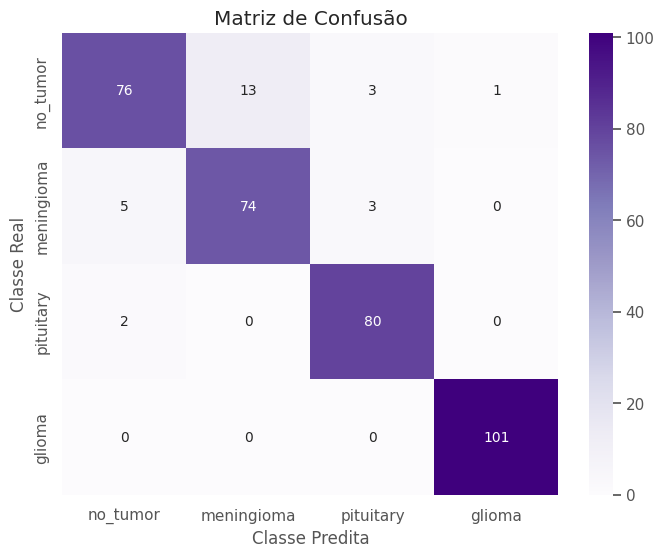

In [28]:

import seaborn as sns
from sklearn.metrics import confusion_matrix

# predição
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)

# matriz de confusão
cm = confusion_matrix(y_test, y_pred)
#print(cm)

# Rótulos das classes
classes = categories

# Plot da matriz de confusão
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Purples", xticklabels=classes, yticklabels=classes)
plt.xlabel('Classe Predita')
plt.ylabel('Classe Real')
plt.title('Matriz de Confusão')
plt.show()


## 10) Verificando as predições do modelo

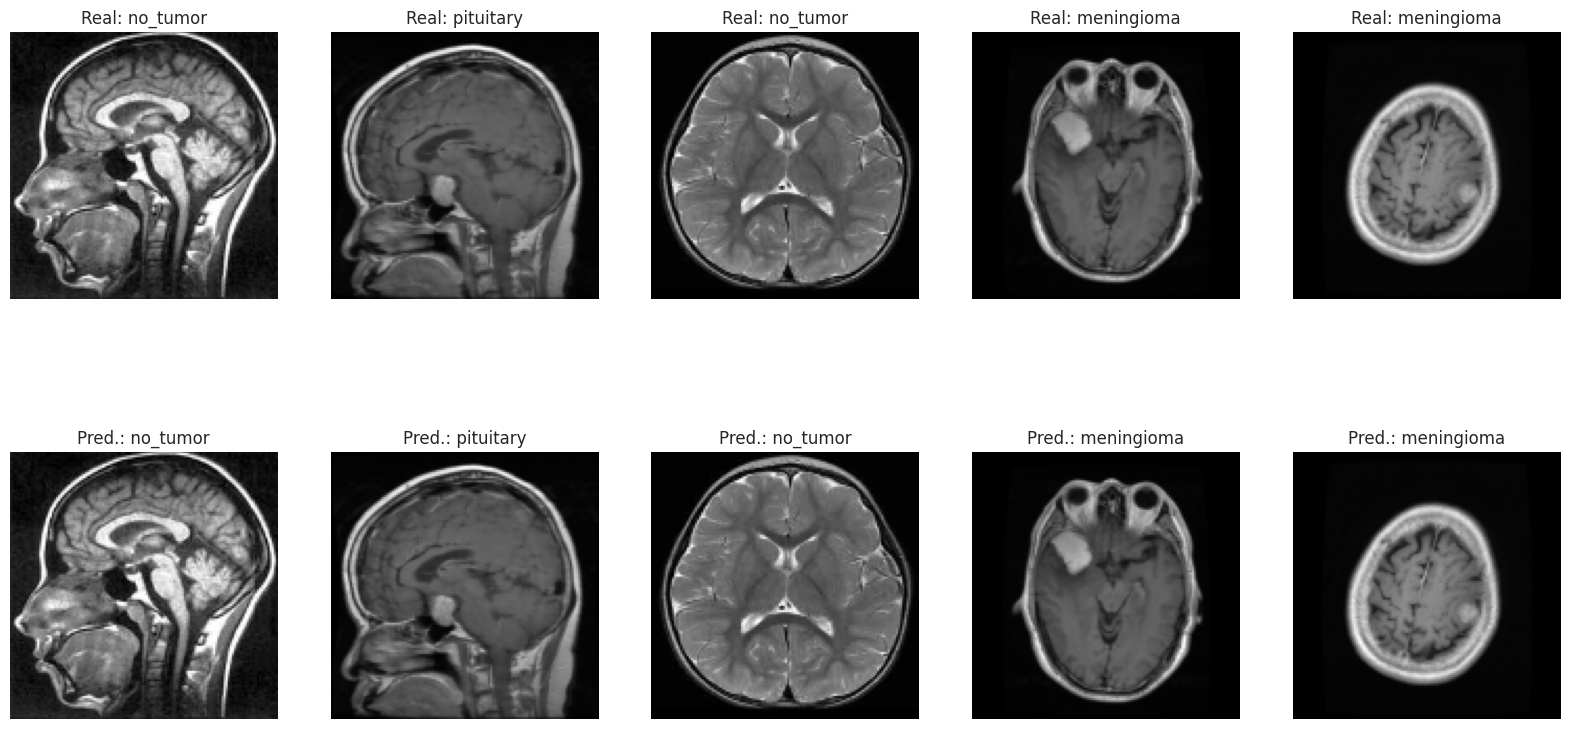

In [31]:
plt.figure(figsize=(20, 10))
for i in range(5):
    plt.subplot(2, 5, i + 1)
    plt.imshow(X_test[i], cmap='gray')
    plt.title('Real: ' + categories[y_test[i]], fontsize=12)
    plt.axis('off')

    plt.subplot(2, 5, i + 6)
    plt.imshow(X_test[i], cmap='gray')
    plt.title('Pred.: ' + categories[y_pred[i]], fontsize=12)
    plt.axis('off')

plt.show()

Implementamos uma rede neural convolucional com uso da biblioteca Keras! 🙃